# **Kunskapskontroll SQL**

Teoretiska Frågor
1. Beskriv kort hur en relationsdatabas fungerar. 
2. Vad menas med “CRUD”-flödet?
3. Beskriv kort vad en “left join” och en “inner join” är. Varför använder man det?
4. Beskriv kort vad indexering i SQL innebär.
5. Beskriv kort vad en vy i SQL är.
6. Beskriv kort vad en lagrad procedur i SQL är.


**Svar:**<br>
1:En relationsdatabas är en databas som består av tabeller, vilka i sin tur innehåller rader och kolumner. Varje tabell har ett schema som bestämmer strukturen för tabellen. Utöver detta har även en tabell en "primary key" och "foreign key" som unik identiferare. <br>
2:Create, Retrieve, Update och Delete. Dessa är de 4 grundläggande operationerna som kan utföras på en databas.<br>
3:En left join sammanflätar två olika tabellar men den nya "tabellen" baseras på den vänstra tabellens rader samt matchande rader från den högra. En innerjoin sammanflätar två olika tabellar men den nya tabellen kommer bara innehålla rader som matchar båda tabellerna.<br>
4:Indexering används i SQL när vi hanterar stora mängder data för att förbättra prestendan/effektivtet av en databas. Indexering gör så att sökningar och sorteringar bl.a. går snabbare.<br>
5:En vy är en tillfällig tabell som inte sparas eller lagras i datan. T.ex. via SELECT nyckeordet i en SQL query.<br>
6:En lagrad procedur i SQL kan jämföras lite med funktion i python. Det är en operation som ofta innehåller mycket SQL syntax och som kan återanvändas.<br>

# Programmeringsuppgift

Scenario<br>
Du har precis börjat arbeta som dataanalytiker på ett företag där ni har en databas som heter AdventureWorks2022. När man börjar på ett nytt företag så behöver man bekanta sig med datan som finns. Du har tre uppgifter:

1. Ge en deskriptiv sammanfattning över databasen AdventureWorks2022. Syftet är att läsaren skall få en god överblick över datan som finns. Du måste här själv bestämma vilka SQL-queries du skall göra genom att undersöka och besluta om vad som är relevant. Självklart kan du, efter att du läst in datan i Python, använda exempelvis Pandas och Matplotlib för din analys. Använd några visualiseringar för att demonstrera intressanta aspekter av datan. Exempelvis hade man kunnat visualisera följande tabell (som tagits fram med en query) med ett stapeldiagram: Figur 1: Exempeltabell

2. Gör en statistisk analys av valfri del av datan. Den skall innehålla åtminstone ett konfidensintervall. Hur tolkar du resultaten?
3. Analysera datan och resultaten du tagit fram. Vilka slutsatser och rekommendationer kan du ge?

# Importerar alla nödvändiga paket och skapar vår anslutning till databasen AdventureWorks 2022

In [82]:
from sqlalchemy import create_engine, URL, inspect
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import shapiro


In [4]:
SERVER = 'localhost'  
DATABASE = 'AdventureWorks2022'

connection_string = f'DRIVER={{ODBC Driver 18 for SQL Server}};SERVER={SERVER};DATABASE={DATABASE};Trusted_Connection=yes;Encrypt=no'

connection_url = URL.create('mssql+pyodbc', query={'odbc_connect': connection_string})

engine = create_engine(connection_url) 

**Vi gör lite tester för att undersöka att vår anslutning till databasen fungerar korrekt.**

In [ ]:
test = inspect(engine)
print(test.get_schema_names())

['db_accessadmin', 'db_backupoperator', 'db_datareader', 'db_datawriter', 'db_ddladmin', 'db_denydatareader', 'db_denydatawriter', 'db_owner', 'db_securityadmin', 'dbo', 'guest', 'HumanResources', 'INFORMATION_SCHEMA', 'Person', 'Production', 'Purchasing', 'Sales', 'sys']


In [160]:
print(test.get_table_names(schema='Production'))

['BillOfMaterials', 'Culture', 'Document', 'Illustration', 'Location', 'Product', 'ProductCategory', 'ProductCostHistory', 'ProductDescription', 'ProductDocument', 'ProductInventory', 'ProductListPriceHistory', 'ProductModel', 'ProductModelIllustration', 'ProductModelProductDescriptionCulture', 'ProductPhoto', 'ProductProductPhoto', 'ProductReview', 'ProductSubcategory', 'ScrapReason', 'TransactionHistory', 'TransactionHistoryArchive', 'UnitMeasure', 'WorkOrder', 'WorkOrderRouting']


# Deskriptiv sammanfattning över databasen AdventureWorks2022

Nu när vi vet att anslutningen fungerar påbörjar vi vår deskriptiva sammanfattning av databasen och vi börjar med att lista alla tabeller i databasen och deras schema.

In [164]:
query = """
SELECT 
Table_schema, Table_name 
FROM 
Information_schema.Tables 
WHERE 
Table_type = 'Base Table';
"""

tables_df = pd.read_sql(query, engine)
print(tables_df)

   Table_schema               Table_name
0         Sales             SalesTaxRate
1         Sales         PersonCreditCard
2        Person              PersonPhone
3         Sales           SalesTerritory
4        Person          PhoneNumberType
..          ...                      ...
67   Production                 Location
68       Person                 Password
69        Sales  SalesPersonQuotaHistory
70       Person                   Person
71        Sales              SalesReason

[72 rows x 2 columns]


Vi fortsätter vår undersökning och använder oss av systemtabeller (sys.tables och sys.partitions) för att ta fram metadata för AdventureWorks2022. Med hjälp av dessa kan vi ta fram information om hur stora dessa tabeller är, dvs hur många rader de innehåller. 

In [165]:
query = """
SELECT 
t.name AS TableName, p.rows AS RowCounts 
FROM 
sys.tables AS t
INNER JOIN 
sys.partitions AS p 
ON 
t.object_id = p.object_id
WHERE 
p.index_id IN (0, 1);
"""

row_counts_df = pd.read_sql(query, engine)
print(row_counts_df)

              TableName  RowCounts
0           DatabaseLog       1596
1              ErrorLog          0
2   ProductProductPhoto        504
3               Address      19614
4           AddressType          6
..                  ...        ...
67               Vendor        104
68            WorkOrder      72591
69     WorkOrderRouting      67131
70      BillOfMaterials       2679
71   MyPersonPhoneTable      19972

[72 rows x 2 columns]


Vi vill skapa en visualisering som listar de största tabellerna (dvs de tabeller med mest rader i databasen). Vi gör detta genom att filtrera bort tabeller som har mindre än 100 rader eftersom att det finns över 72 tabeller och det skulle inte få plats i vår visualisering och därefter sorterar vi efter antalet rader fallande.

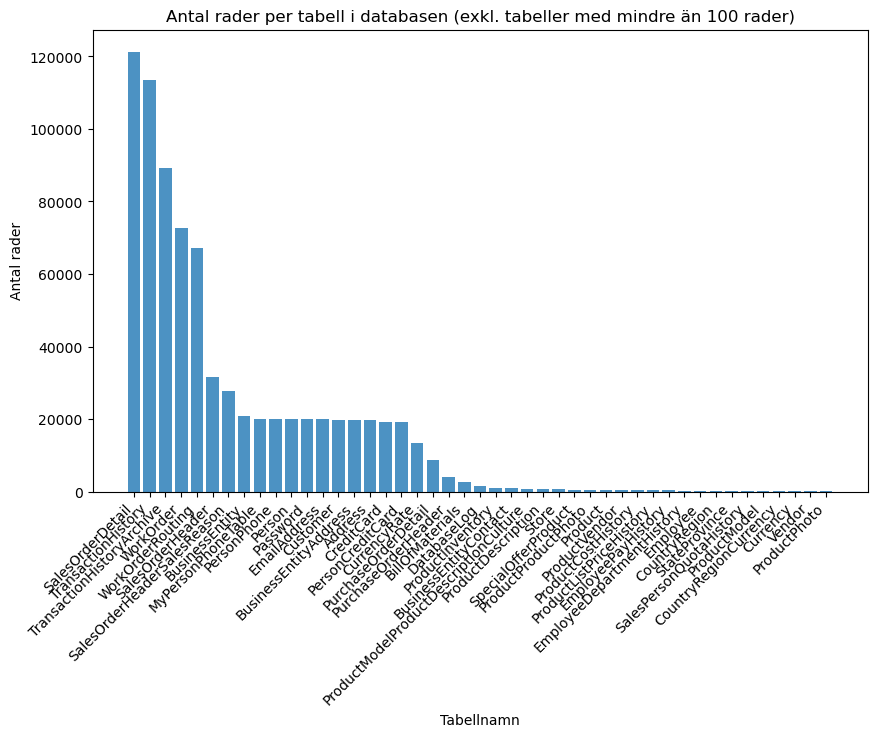

In [120]:
filtered_row_counts_df = row_counts_df[row_counts_df['RowCounts'] > 100]

plt.figure(figsize=(10, 6))
    
filtered_row_counts_df = filtered_row_counts_df.sort_values(by='RowCounts', ascending=False)

plt.bar(filtered_row_counts_df['TableName'], filtered_row_counts_df['RowCounts'], alpha=0.8)
plt.title('Antal rader per tabell i databasen (exkl. tabeller med mindre än 100 rader)')
plt.xlabel('Tabellnamn')
plt.ylabel('Antal rader')
plt.xticks(rotation=45, ha='right')
plt.show()


Vi ser att SalesOrderDetail är den största tabellen i databasen och vi väljer att undersöka denna tabell lite närmare. Vi använder oss av inbyggda metoder för att få en överblick över all data i SalesOrderDetail.

In [94]:
query = "SELECT * FROM Sales.SalesOrderDetail;"
sales_data = pd.read_sql(query, engine)

print(sales_data.info())

print(sales_data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121317 entries, 0 to 121316
Data columns (total 11 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   SalesOrderID           121317 non-null  int64         
 1   SalesOrderDetailID     121317 non-null  int64         
 2   CarrierTrackingNumber  60919 non-null   object        
 3   OrderQty               121317 non-null  int64         
 4   ProductID              121317 non-null  int64         
 5   SpecialOfferID         121317 non-null  int64         
 6   UnitPrice              121317 non-null  float64       
 7   UnitPriceDiscount      121317 non-null  float64       
 8   LineTotal              121317 non-null  float64       
 9   rowguid                121317 non-null  object        
 10  ModifiedDate           121317 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(3), int64(5), object(2)
memory usage: 10.2+ MB
None
        SalesOrderID  

Baserat på ovanstående information bestämmer vi att undersöka närmare kring kolumerna ProductID och OrderQty för att se hur många produkter det finns samt vilka av produkterna som är de mest populära baserat på hur många ordrar som läggs på dessa.

In [25]:
query = """SELECT TOP 10
ProductID, SUM(OrderQty) AS TotalQuantity 
FROM 
Sales.SalesOrderDetail
GROUP BY 
ProductID
ORDER BY 
TotalQuantity DESC;"""

order_qty_per_product = pd.read_sql(query, engine)

Vi skapar ett cirkeldiagram för att visualisera vår SQL query som har tagit from de 10 mest populära produkterna baserat på hur många ordrar som läggs på dessa produkter.

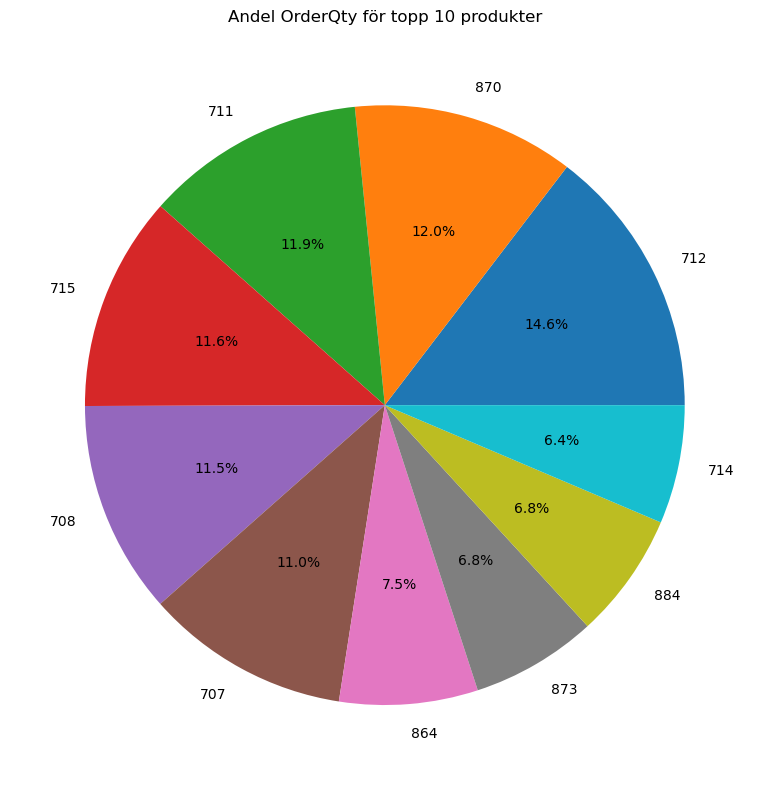

In [ ]:
plt.figure(figsize=(8, 8))
plt.pie(order_qty_per_product['TotalQuantity'], labels=order_qty_per_product['ProductID'].astype(str), autopct='%.1f%%')
plt.title('Andel OrderQty för topp 10 produkter')
plt.show()

Utifrån ovanstående cirkeldiagram kan vi se att ProduktID 712 är den mest populära produkten baserat på totala antal ordrar som har lagts. Utifrån detta, kan vi undersöka närmare och lägga till försäljningsiffror.

In [28]:
query = """SELECT 
ProductID, SUM(LineTotal) AS TotalSales, SUM(OrderQty) AS TotalQuantity
FROM 
Sales.SalesOrderDetail
WHERE 
ProductID IN (712, 870, 711, 715, 708, 707, 864, 873, 884, 714)
GROUP BY 
ProductID
ORDER BY 
TotalQuantity DESC;"""
    
sales_stats = pd.read_sql(query, engine)

Vi skapar ett linjediagram för att visa försäljningen och bibehåller ordningen där från vänster till höger den mest populära produkten för att få en enkel överblick om försäljningen är i linje med antalet ordrar.

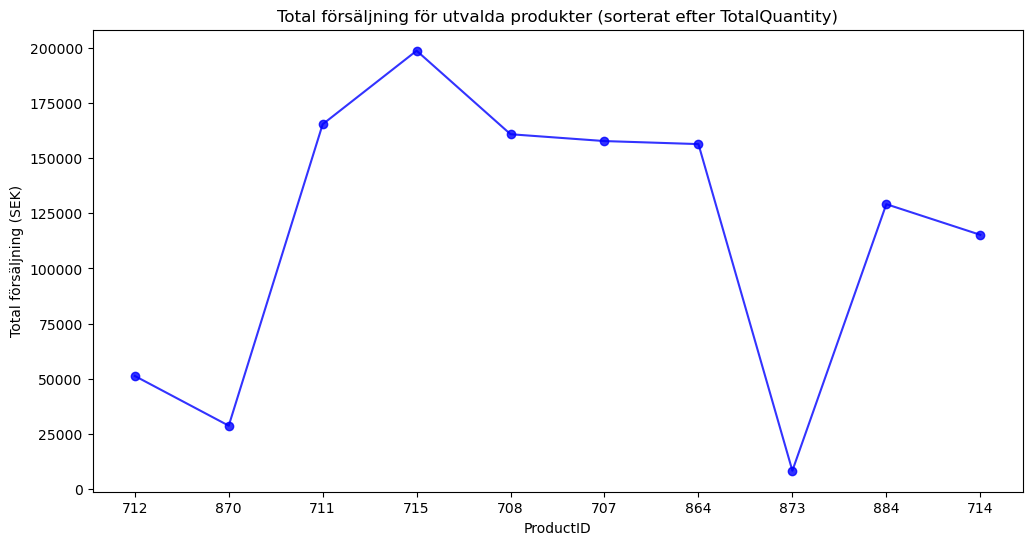

In [124]:
plt.figure(figsize=(12, 6))
plt.plot(sales_stats['ProductID'].astype(str), sales_stats['TotalSales'], marker='o', color='blue', alpha=0.8)
plt.title('Total försäljning för utvalda produkter (sorterat efter TotalQuantity)')
plt.xlabel('ProductID')
plt.ylabel('Total försäljning (SEK)')
plt.show()


Vi ser att även ifall produktID 712 och 870 är de mest populära produkterna betyder det inte att försäljningen är bäst för dessa. 715 vilket är den 4:e mest populära produkten utifrån antalet ordrar har faktiskt högst försäljningssiffror.<br>
Baserat på detta, väljer vi att undersöka försäljningssiffror ännu närmare, fast nu med fokus på vinst (försäljning minus kostnad)

SQL Query för att ta fram: Top 10 produkter baserat på vinst (Försäljning minus kostnad)

In [ ]:
query = """SELECT TOP 10
B.ProductID AS Product, SUM(B.LineTotal) AS TotalSales, SUM(B.OrderQty * C.StandardCost) AS TotalCost, SUM(B.LineTotal) - SUM(B.OrderQty * C.StandardCost) AS Profit
FROM 
Sales.SalesOrderHeader AS A
INNER JOIN 
Sales.SalesOrderDetail AS B
ON A.SalesOrderID = B.SalesOrderID
INNER JOIN 
Production.Product AS C
ON B.ProductID = C.ProductID
GROUP BY 
B.ProductID
ORDER BY 
Profit DESC;"""
    
profit_per_product = pd.read_sql(query, engine)

Vi visualiserar detta med ett stapeldiagram:

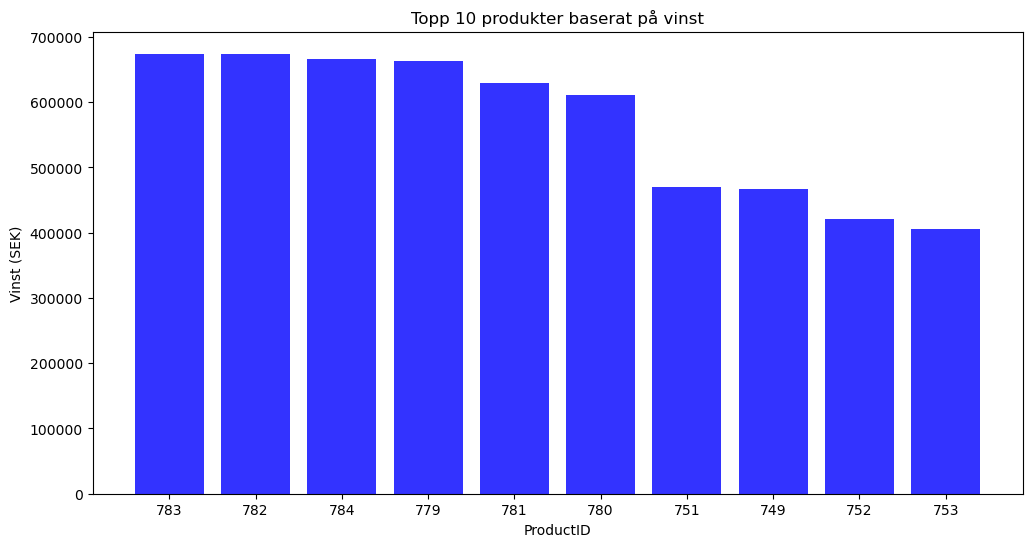

In [ ]:
plt.figure(figsize=(12, 6))
plt.bar(profit_per_product['Product'].astype(str), profit_per_product['Profit'], color='blue', alpha=0.8)
plt.title('Topp 10 produkter baserat på vinst')
plt.xlabel('ProductID')
plt.ylabel('Vinst (SEK)')
plt.show()


Här får vi en helt annan bild av vilka produkter som presterar bäst fast utifrån marginal istället för antalet ordrar.

# **Statistisk Analys**

Vi väljer att utföra en statistisk analys av den mest lönsamma produkten baserat på produkten som har bäst marginal, med andra ord Produkt 783. För att utföra vår statistiska analys behöver vi fram all data för 783. Vi skapar en query som består av två delar: en underquery som tar fram den mest lönsamma produkten (TOP 1) utifrån försäljning minus antaler ordrar multiplicerat med konstnaden. Den andra delen av queryn använder denna informationen för att ta fram information om varje transaktion för den här produkten. 

In [57]:
query = """
SELECT 
B.LineTotal AS Sale, B.OrderQty * C.StandardCost AS Cost, B.LineTotal - (B.OrderQty * C.StandardCost) AS Profit
FROM 
Sales.SalesOrderHeader AS A
INNER JOIN 
Sales.SalesOrderDetail AS B
ON A.SalesOrderID = B.SalesOrderID
INNER JOIN 
Production.Product AS C
ON B.ProductID = C.ProductID
WHERE 
B.ProductID = (
SELECT TOP 1 
B.ProductID
FROM 
Sales.SalesOrderHeader AS A
INNER JOIN 
Sales.SalesOrderDetail AS B
ON A.SalesOrderID = B.SalesOrderID
INNER JOIN 
Production.Product AS C
ON B.ProductID = C.ProductID
GROUP BY 
B.ProductID
ORDER BY 
SUM(B.LineTotal) - SUM(B.OrderQty * C.StandardCost) DESC
);
"""
product_id_stats = pd.read_sql(query, engine)

# Nu när vi har vår data kan vi utföra vår statistiska analys av Produkt 783.

Vi börjar med filtrera ut vinsten och använda av oss inbyggda metoder för att få fram medelvärde och standardavvikelsen för vinsten för produkt 783. För att testa ifall vi kan skapa ett konfidensintervall utifrån en normalfördelning testar vi denna data med hjälp av ett Shapiro Wilks test. Vi vill därefter visualisera detta tillsammans med konfidensintervall så vi plottar upp ett histogram för detta. I vårt histogram vill vi highlighta vårt medelvärde och konfidensintervall i histogram så vi skapar vertikala linjer för detta.

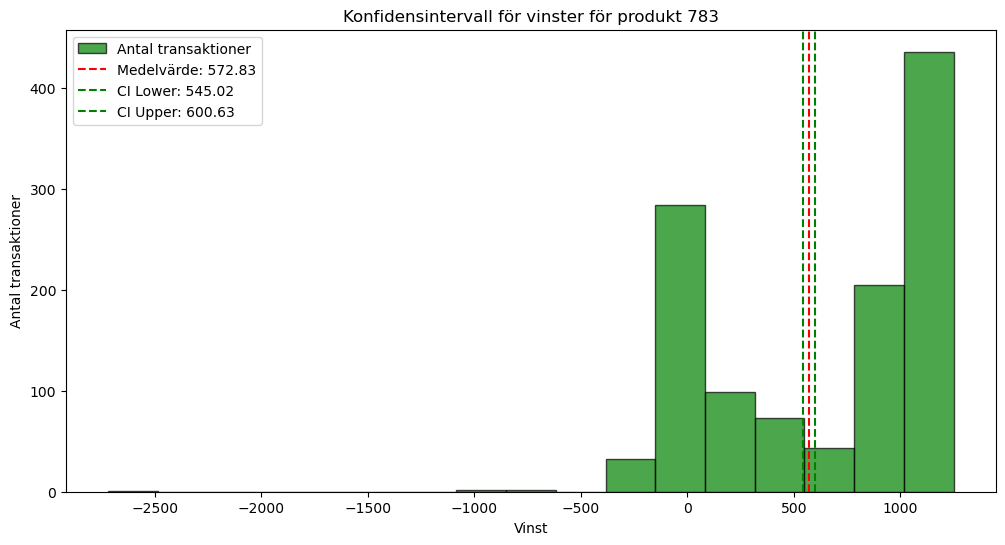

Shapiro-Wilk test: p-värde = 1.241534484186446e-34
Datan följer inte en normalfördelning.


In [168]:
profits = product_id_stats['Profit']
mean_profit = profits.mean()
std_profit = profits.std()

plt.figure(figsize=(12, 6))
counts, bins, patches = plt.hist(profits, bins=17, alpha=0.7, color='green', edgecolor='black', label='Antal transaktioner')

plt.axvline(mean_profit, color='red', linestyle='--', label=f'Medelvärde: {mean_profit:.2f}')
ci_lower = mean_profit - 1.96 * (std_profit / np.sqrt(len(profits)))
ci_upper = mean_profit + 1.96 * (std_profit / np.sqrt(len(profits)))
plt.axvline(ci_lower, color='green', linestyle='--', label=f'CI Lower: {ci_lower:.2f}')
plt.axvline(ci_upper, color='green', linestyle='--', label=f'CI Upper: {ci_upper:.2f}')

plt.title('Konfidensintervall för vinster för produkt 783')
plt.xlabel('Vinst')
plt.ylabel('Antal transaktioner')
plt.legend()
plt.show()

stat, p = shapiro(product_id_stats['Profit'])
print(f"Shapiro-Wilk test: p-värde = {p}")
if p > 0.05:
    print("Datan följer en normalfördelning.")
else:
    print("Datan följer inte en normalfördelning.")

# Analys, reflektion och tolkning

Eftersom datan inte följer en normalfördelning enligt Shapiro Wilks testet fortsatte jag att undersöka andra typer av data i olika tabeller i databasen AdventureWorks2022 som eventuellt kunde följa en normalfördelning. Jag undersökte Orderqty från SalesOrderDetail och testade med Shapiro Wilks test om datan eventuellt där var normalfördelad men fick liknande svar att nej det är den inte. Jag testade även Standardcost från Production.product, Rate från Employeepayhistory, LineTotal från de mest populära produkterna men jag fick alltid samma resultat från Shapiro Wilk, ingen av datan jag tog fram följde en normalfördelning. Jag har valt att inte ta med dessa tester i detta Jypter notebook men det finns i separat notebook om intresse skulle finnas för att se dessa. Så jag började kika på alternativa metoder för att ta fram konfidensintervall för data som inte följde en normalfördelning och hittade att man kan använda av sig av en metod som heter "Bootstrap". I en Bootstrap metod dras slumpmässiga prover med återläggning (i detta fall 1000 ggr) ifrån vårt dataset och vi beräknar medelvärdet på varje urval. Vi sparar medelvärdet för varje urval i listan "bootstrap_means". Därefter skapar vi vårt konfidensintervall på undre och övre gräns på 2,5% respektive 97,5%. Vad som är intressant att observera här är att även ifall vi skapade ett konfidensintervall utifrån data som följer en normalfördelning eller bootstrap så är våra intervall relativt lika. Utifrån ovanstående data där är intervallet 600,63 -> 545,02 medans i bootstrap metoden (nedanför) har vi intervallet 599,85 till 541,50. Ett intervall på 55,61 respektive 58,35. Medelvärdet för ovanstående data ligger på 572.83 medans i bootstrap har vi ett exakt likadant medelvärde. Eftersom medelvärdet i de båda metoderna är identitiska så ger detta oss en en hög tillförlitghet till att metoden vi har valt är rimlig och korrekt. 

95% Konfidensintervall (Bootstrap): (543.09, 599.48)


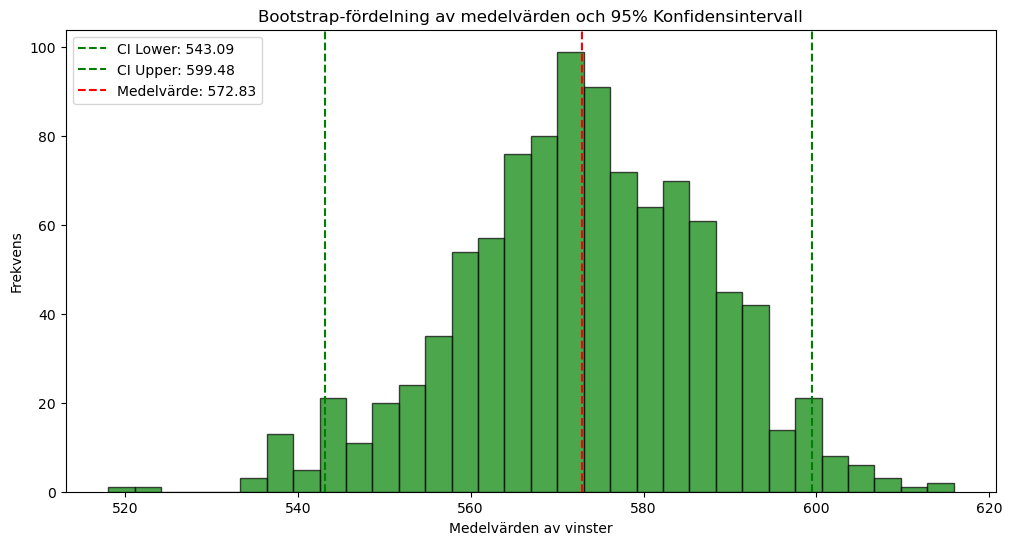

In [156]:

n = 1000  
bootstrap_means = []

for _ in range(n):
    sample = profits.sample(frac=1, replace=True)
    bootstrap_means.append(sample.mean())

ci_lower = np.percentile(bootstrap_means, 2.5)
ci_upper = np.percentile(bootstrap_means, 97.5)

print(f"95% Konfidensintervall (Bootstrap): ({ci_lower:.2f}, {ci_upper:.2f})")

plt.figure(figsize=(12, 6))
plt.hist(bootstrap_means, bins=32, alpha=0.7, color='green', edgecolor='black')
plt.axvline(ci_lower, color='green', linestyle='--', label=f'CI Lower: {ci_lower:.2f}')
plt.axvline(ci_upper, color='green', linestyle='--', label=f'CI Upper: {ci_upper:.2f}')
plt.axvline(mean_profit, color='red', linestyle='--', label=f'Medelvärde: {mean_profit:.2f}')
plt.title('Bootstrap-fördelning av medelvärden och 95% Konfidensintervall')
plt.xlabel('Medelvärden av vinster')
plt.ylabel('Frekvens')
plt.legend()
plt.show()

# Slutsats

Medelvärde för vinsten ligger på 572,83 med ett konfidensintervall som är beräknat med hjälp av Bootstrap-fördelning som ligger mellan 541,50 till 599,85. Vi kan med 95% säkerhet säga att medelvärdet för vinsten för den mest populära produkten (783) ligger inom detta intervall. Eftersom vi har ett relativt smalt intervall kan vi säga att produkten är stabil och har en bra genomsnittlig lönsamhet och därmed har vi ett förtroende för produkten och dess framtida lönsamhet kommer att fortlöpa.

# Rekommendationer

Eftersom i vår analys har vi bara gjort en statistisk analys på den mest lönsamma produkten. För att få en mer övergripande och bättre bild av AdventureWorks202s alla top produkter och dess lönsamhet bör liknande analyser göras på alla top 10 lönsamma produkter och sedan jämföras mot varandra för att se vilka produkter har mest stabilitet i vinsterna. Utifrån denna analys kan vi mest bara spekulera om intervallet är relativt smalt eller brett eftersom vi inte vet de andra produkters intervaller. 

# Executive Summary

Vi har 72 tabeller i vår databas och den största tabellen som innehåller mest information är SalesOrderDetail.<br>
Våra top 10 mest populära produkter baserat på antal ordrar är:<br>
712, 870, 711, 715, 708, 707, 864, 873, 884, 714<br>
Produkt 712 är vår mest populära produkt.<br>
Ingen av våra 10 mest populära produkter är med i vår top 10 mest lönsamma produkter. Våra top 10 mest lönsamma produkter är istället:<br>
783, 782, 784, 779, 781, 780, 751, 749, 751, 753<br>
Produkt 783 är vår mest lönsamma produkt med bäst marginal.<br>
Utifrån en statistisk analys av vår mest lönsamma produkt 783 är våra framtida prognoser goda inför fortsatt lönsamhet just för produkt 783. <br>
Rekommendation till ledning är att fortsätta utföra statistiska analyser av våra top produkter för att jämföra stabilitet i vinst och sedan prioritera investeringar och resurser i produkter som har stabila vinster och marginaler.


# Datum för muntlig presentation och inspelning:

2024-01-04

# Självutvärdering

**Utmaningar som jag har haft:** <br>
Pga tidigare planerad semester-resa, sjukdom samt högtider har jag tyvärr inte kunnat vara lika aktiv på lektioner som man hade önskat att man kunde vara och därmed missat genomgånger vilket har fått mig att känna mig mer stressad och lite vilsen i direktion samt anvisningar kring hur uppgiften ska genomföras. Det har jag såklart ingen annan att skylla på förutom mig själv, (förutom oturen att bli magsjuk från resan vilket är svårt att ta med i planering från början vilket gjorde saker och ting ännu svårare). Men sånt är livet och det är bara att göra ens bästa och hoppas att man har tolkat uppgiften korrekt.<br>
**Vilket betyg du anser att du skall ha och varför?**<br>
Jag tycker att utifrån mina goda SQL kunskaper har visat i denna inlämningsuppgift att jag behärskar SQL utifrån kursplanens kriterier därmed ett godkänt betyg. <br>
**Tips du hade gett till dig själv i början av kursen nu när du slutfört den.**<br>
Häng alltid med på lektioner och använd dina kurskamrater vid osäkerhet/tveksamheter!
